<h1 style="text-align:center;"><b>Laboratorio 1</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Importar datos

In [14]:
#CONSUMO

archivo = 'Datos/Consumo.xlsx'
df = pd.read_excel(archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

#Se saca las columnas necesarias
columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel alto azufre']
consumo = df[columnas_deseadas]
print('\nDatos filtrados:')
consumo.head()

train_size = int(len(consumo) * 0.7)
train_consumo = consumo[0:train_size]
test_consumo = consumo[train_size:len(consumo)]
print(train_consumo)


Datos filtrados:
            Gasolina superior  Gasolina regular  Diesel alto azufre
Fecha                                                              
2000-01-01          308156.82         202645.20           634667.06
2000-02-01          307766.31         205530.96           642380.66
2000-03-01          331910.29         229499.56           699807.25
2000-04-01          315648.08         210680.40           586803.98
2000-05-01          319667.97         208164.34           656948.20
...                       ...               ...                 ...
2017-02-01          526888.94         453665.32                0.00
2017-03-01          592249.34         523943.60                0.00
2017-04-01          530345.96         500063.03                0.00
2017-05-01          588861.62         516884.37                0.00
2017-06-01          549378.05         478491.95                0.00

[210 rows x 3 columns]


In [15]:
#IMPORTACIONES

archivo = 'Datos/Importaciones.xlsx'
df = pd.read_excel(archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

#Se saca las columnas necesarias
columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel alto azufre']
importaciones = df[columnas_deseadas]
print('\nDatos filtrados:')
importaciones.head()

train_size = int(len(importaciones) * 0.7)
train_importa = importaciones[0:train_size]
test_importa = importaciones[train_size:len(importaciones)]
print(train_importa)


Datos filtrados:
            Gasolina superior  Gasolina regular  Diesel alto azufre
Fecha                                                              
2001-01-01          373963.96         177776.50           566101.99
2001-02-01          243091.07         123115.99           489525.80
2001-03-01          312084.38         161726.42           575559.68
2001-04-01          285054.89         127338.74           437745.42
2001-05-01          300913.67         168730.19           552609.13
...                       ...               ...                 ...
2017-05-01          442311.09         386088.18           889926.86
2017-06-01          582374.34         519389.66           902659.00
2017-07-01          769214.06         433026.08           994338.30
2017-08-01          607368.72         592103.31           846696.35
2017-09-01          401678.98         316435.22           925397.87

[201 rows x 3 columns]


## Convertir en series de tiempo

In [29]:
#Gasolina superior
ts_consumo_superior = consumo['Gasolina superior']
ts_importa_superior = importaciones['Gasolina superior']

#Gasolina regular
ts_consumo_regular = consumo['Gasolina regular']
ts_importa_regular = importaciones['Gasolina regular']

#Diesel alto azufre
ts_consumo_diesel = consumo['Diesel alto azufre']
ts_importa_diesel = importaciones['Diesel alto azufre']

## Análisis exploratorio

In [30]:
print("Consumo")
print(ts_consumo_superior.describe(),ts_consumo_regular.describe(),ts_consumo_diesel.describe())

print("\nImportaciones")
print( ts_importa_superior.describe(),  ts_importa_regular.describe(),  ts_importa_diesel.describe())

Consumo
count       300.000000
mean     470248.678849
std      113504.653305
min      300242.781667
25%      383931.904375
50%      423319.540000
75%      573704.195000
max      786598.120000
Name: Gasolina superior, dtype: float64 count       300.000000
mean     397478.894458
std      219102.049432
min      160741.900000
25%      215650.312917
50%      288193.130000
75%      548073.682500
max      938086.570000
Name: Gasolina regular, dtype: float64 count    3.000000e+02
mean     5.144313e+05
std      3.688977e+05
min      0.000000e+00
25%      0.000000e+00
50%      6.721700e+05
75%      7.791021e+05
max      1.149175e+06
Name: Diesel alto azufre, dtype: float64

Importaciones
count    2.880000e+02
mean     4.909544e+05
std      1.565581e+05
min      1.702925e+05
25%      3.693299e+05
50%      4.813002e+05
75%      6.083053e+05
max      1.227174e+06
Name: Gasolina superior, dtype: float64 count    2.880000e+02
mean     4.129493e+05
std      2.432627e+05
min      8.101530e+04
25%      

Se puede ver que la gasolina Diesel tiene la media de consumo más alta (735 000), casi el doble de la media de consumo de la gasolina superior (420 000). A su vez, la gasolina superior tiene una media de consumo de casi el doble de la media de la gasolina regular (270 000). La desviación estándar coincide en las diferencias (es decir, el diesel tiene la desviación más grande, seguido de superior y por último regular). 

En cuanto a las importaciones, se mantiene el orden. Se puede ver que la gasolina tiene uan media de importación de alrededor de 800 000, mientras que la gasdolina superior tiene una de alrededor de 430 000. El promedio de importaciones de la gaslolina regular es de alrededor 280 000. 

Se puede observar que el valor de la media consumo medio es alrededor de 10 000 menor que las importaciones.

### Análisis de comportamiento

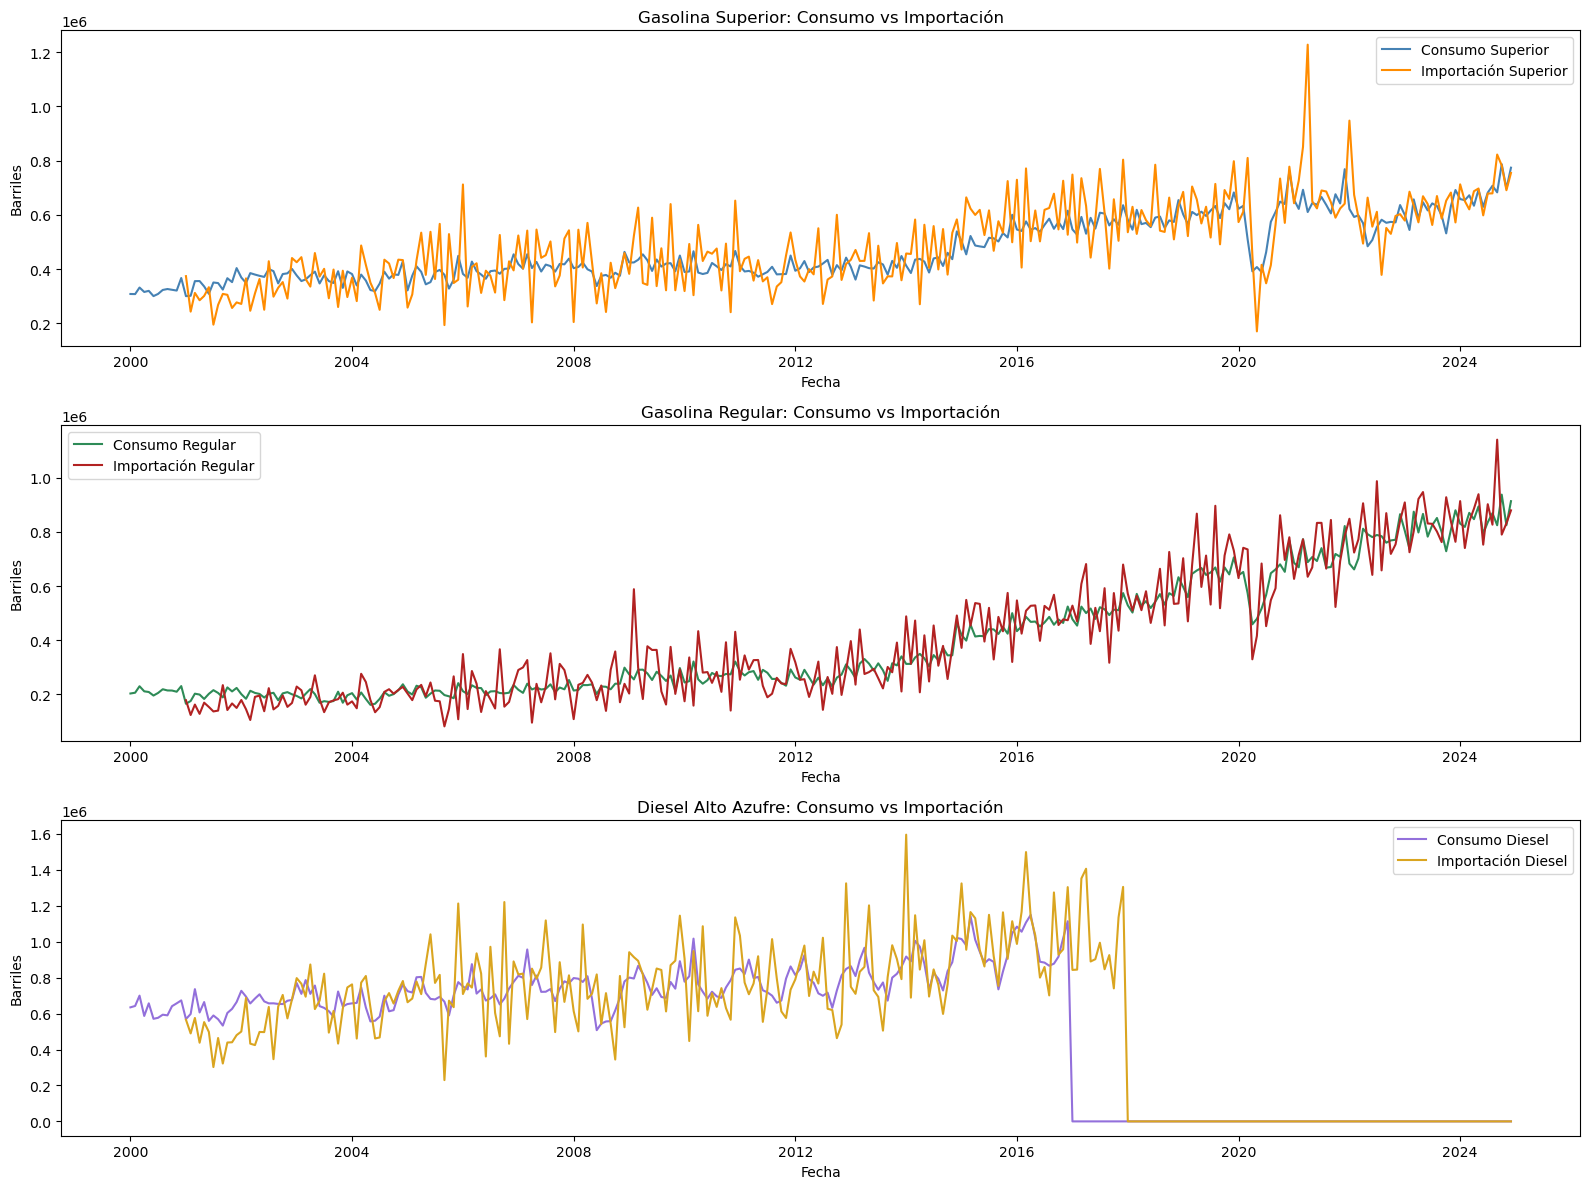

In [31]:
#Gasolina Superior
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(ts_consumo_superior, label='Consumo Superior', color='steelblue')
plt.plot(ts_importa_superior, label='Importación Superior', color='darkorange')
plt.title('Gasolina Superior: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()

#Gasolina Regular
plt.subplot(3, 1, 2)
plt.plot(ts_consumo_regular, label='Consumo Regular', color='seagreen')
plt.plot(ts_importa_regular, label='Importación Regular', color='firebrick')
plt.title('Gasolina Regular: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()

#Diesel Alto Azufre
plt.subplot(3, 1, 3)
plt.plot(ts_consumo_diesel, label='Consumo Diesel', color='mediumpurple')
plt.plot(ts_importa_diesel, label='Importación Diesel', color='goldenrod')
plt.title('Diesel Alto Azufre: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()
plt.tight_layout()
plt.show()

1. Para la gasolina superior se puede observar que el consumo e importación está en constante crecimiento desde el 2000 hasta el 2020, donde debido a la pandemia se registra una baja abrupta en el consumo e importación. Luego en el 2021 se registra el pico más alto en la importación y en los siguientes años tiene un constante crecimiento.

2. Para la gasolina regular se puede observar que el consumo e importación está en constante crecimiento desde el 2000 hasta el 2020, donde debido a la pandemia también se registra una baja abrupta tanto de consumo e importación para luego seguir creciendo constantemente y en esos años alcanzar los picos más altos.

3. Para el diesel de alto azufr se tiene un constante crecimiento en consumo e importación desde el 2000 con varios picos en diversos años siendo el más alto en 2014. Luego se observa que en 2017 el consumo cae abruptamente hasta que se deja de consumir. En el caso de las importaciones ocurre lo mismo pero hasta el año 2018, donde cae abruptamente hasta dejar de importarse hasta la actualidad.

### Análisis de normalidad

In [19]:
from scipy.stats import shapiro
stat1, p1 = shapiro(ts_consumo_superior)
stat2, p2 = shapiro(ts_importa_superior)
stat3, p3 = shapiro(ts_consumo_regular)
stat4, p4 = shapiro(ts_importa_regular)
stat5, p5 = shapiro(ts_consumo_diesel)
stat6, p6 = shapiro(ts_importa_diesel)

print(p1, p2, p3, p4, p5, p6)

9.136041845334487e-10 0.0004653665294097945 2.3850258324972416e-14 4.176536100682387e-09 9.889035453091424e-14 0.006733239063708438


El valor-p es menor a 0.05 para todas las variables, lo que indica que todas estan distribuidas normalmente

### Meses en los que más importaciones hay

In [32]:
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

promedio_consumo_superior = ts_consumo_superior.groupby(ts_consumo_superior.index.month).mean()
promedio_consumo_superior.index = meses
print('Consumo\n')
print(promedio_consumo_superior)

promedio_consumo_regular = ts_consumo_regular.groupby(ts_consumo_regular.index.month).mean()
promedio_consumo_regular.index = meses
print(promedio_consumo_regular)

promedio_consumo_diesel = ts_consumo_diesel.groupby(ts_consumo_diesel.index.month).mean()
promedio_consumo_diesel.index = meses
print(promedio_consumo_diesel)

print('\nImportaciones')

promedio_importa_superior = ts_importa_superior.groupby(ts_importa_superior.index.month).mean()
promedio_importa_superior.index = meses
print(promedio_importa_superior)

promedio_importa_regular = ts_importa_regular.groupby(ts_importa_regular.index.month).mean()
promedio_importa_regular.index = meses
print(promedio_importa_regular)

promedio_importa_diesel = ts_importa_diesel.groupby(ts_importa_diesel.index.month).mean()
promedio_importa_diesel.index = meses
print(promedio_importa_diesel)

Consumo

Enero         465444.133900
Febrero       449589.379500
Marzo         485997.725420
Abril         454148.854300
Mayo          455444.417900
Junio         437856.819500
Julio         471367.123900
Agosto        478979.751100
Septiembre    456616.414433
Octubre       481344.612300
Noviembre     469803.929900
Diciembre     536390.984033
Name: Gasolina superior, dtype: float64
Enero         383185.687333
Febrero       369956.867333
Marzo         411988.348533
Abril         394359.671433
Mayo          393026.630933
Junio         378066.094133
Julio         398433.337333
Agosto        402503.807333
Septiembre    385355.633152
Octubre       405274.873333
Noviembre     394711.527933
Diciembre     452884.254705
Name: Gasolina regular, dtype: float64
Enero         542594.861848
Febrero       534185.231238
Marzo         595864.636895
Abril         543003.669910
Mayo          520845.624667
Junio         467567.321829
Julio         475682.383192
Agosto        478067.624152
Septiembre    44

Se puede observar que aunque el cambio no es tan signficativo si existen diferencias por mes. Por ejemplo, el consumo de gasolina sin importar el tipo es mas alto en diciembre y bajo en febrero. Para las importaciones el diesel tiene un valor mucho mas alto en diciembre, pero los demas tipos no demuestran tanta diferencia.